# Data preprocessing (just check)

In [1]:
from __future__ import print_function
import os
import argparse
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
import time

import datetime
import os
import glob
import warnings

In [2]:
output_dir = './output_i/raw/'
cropped_dir = './output_i/cropped/'
dataset_dir = './data/i_screamkids/raw/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
image_files = glob.glob(f'{dataset_dir}**/*.[jJ][pP][gG]', recursive=True) + \
              glob.glob(f'{dataset_dir}**/*.[jJ][pP][eE][gG]', recursive=True) + \
              glob.glob(f'{dataset_dir}**/*.[pP][nN][gG]', recursive=True)
image_files.sort()
print("Total image files: {}".format(len(image_files)))

Total image files: 1061


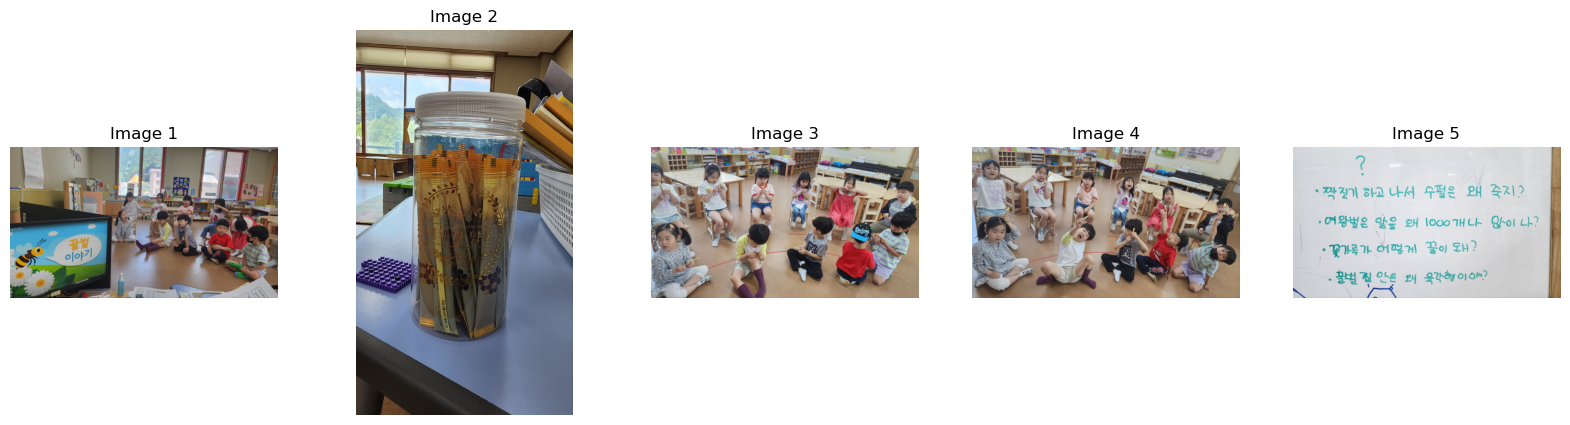

In [4]:
# Plot the first 5 images from the image_files list
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

for i, image_file in enumerate(image_files[:num_images_to_plot]):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')

plt.show()

# RetinaFace

In [ ]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [ ]:
def detect(image_path, detector, options):
    # set options
    torch.set_grad_enabled(False)
    cfg = options['cfg']
    cpu = options['cpu']
    confidence_threshold = options['confidence_threshold']
    top_k = options['top_k']
    nms_threshold = options['nms_threshold']
    keep_top_k = options['keep_top_k']
    save_image = options['save_image']
    vis_thres = options['vis_thres']
    count = options['count']
    
    cudnn.benchmark = True
    device = torch.device("cpu" if cpu else "cuda")
    detector = detector.to(device)

    resize = 1
    print(f"Processing file: {image}")
    
    for _ in range(count):
        # read image
        img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = np.float32(img_raw)

        # pre-processing
        im_height, im_width, _ = img.shape
        scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
        img -= (104, 117, 123)
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.to(device)
        scale = scale.to(device)

        # inference
        tic = time.time()
        loc, conf, landms = detector(img)
        print('detector forward time: {:.4f}'.format(time.time() - tic))
        
        # prior boxes
        priorbox = PriorBox(cfg, image_size=(im_height, im_width))
        priors = priorbox.forward()
        priors = priors.to(device)
        prior_data = priors.data
        boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
        boxes = boxes * scale / resize
        boxes = boxes.cpu().numpy()
        scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
        landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
        scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                img.shape[3], img.shape[2]])
        scale1 = scale1.to(device)
        landms = landms * scale1 / resize
        landms = landms.cpu().numpy()

        # ignore low scores
        inds = np.where(scores > confidence_threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # keep top-K before NMS
        order = scores.argsort()[::-1][:top_k]
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]

        # do NMS
        dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
        keep = py_cpu_nms(dets, nms_threshold)
        # keep = nms(dets, nms_threshold,force_cpu=cpu)
        dets = dets[keep, :]
        landms = landms[keep]

        # keep top-K faster NMS
        dets = dets[:keep_top_k, :]
        landms = landms[:keep_top_k, :]

        dets = np.concatenate((dets, landms), axis=1)
        
    # show image
    if save_image:
        for b in dets:
            if b[4] < vis_thres:
                continue
            text = "{:.4f}".format(b[4])
            b = list(map(int, b))
            cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
            cx = b[0]
            cy = b[1] + 12
            cv2.putText(img_raw, text, (cx, cy),
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

            # landms
            cv2.circle(img_raw, (b[5], b[6]), 1, (0, 255, 0), 4)
            cv2.circle(img_raw, (b[7], b[8]), 1, (0, 0, 255), 4)
            cv2.circle(img_raw, (b[9], b[10]), 1, (0, 0, 255), 4)
            cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
            cv2.circle(img_raw, (b[13], b[14]), 1, (0, 0, 255), 4)
            
        # save image
        filename = os.path.basename(image)
        filepath = os.path.dirname(image)
        
        relative_path = os.path.relpath(filepath, dataset_dir)
        output_path = os.path.join(output_dir, relative_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        output_file = os.path.join(output_path, f"output_{filename}")
        print('writing', output_file)
        cv2.imwrite(output_file, img_raw)
    return dets

In [7]:
def crop_and_align(image_path, faces, options):
    desired_landmarks = np.array([
        [38.2946, 51.6963],  # 왼쪽 눈
        [73.5318, 51.6963],  # 오른쪽 눈
        [56.0252, 71.7366],  # 코 끝
        [41.5493, 92.3655],  # 왼쪽 입꼬리
        [70.7299, 92.3655],  # 오른쪽 입꼬리
    ], dtype=np.float32)
    
    count = 0
    vis_thres = options['vis_thres']
    
    # exception: no faces
    if faces.shape[0] == 0:
        print("No faces.")
        return
    
    # load image
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    for i in range(faces.shape[0]):
        
        # only consider high visual threshold
        if faces[i][4] < vis_thres:
            continue
        
        # extract features and clamping
        bx1, by1, bx2, by2 = faces[i][:4].astype(int)
        bx1 = max(0, bx1)
        by1 = max(0, by1)
        bx2 = min(img_raw.shape[1], bx2)
        by2 = min(img_raw.shape[0], by2)
        
        offset = np.array([bx1, by1])
        main_landmarks = faces[i][5:].reshape(5, 2)
        main_landmarks = main_landmarks - offset
        
        #crop image
        img_cropped = img_raw[by1:by2, bx1:bx2]
        
        # transform
        transform_matrix = cv2.estimateAffinePartial2D(main_landmarks, desired_landmarks)[0]
        aligned_img = cv2.warpAffine(img_cropped, transform_matrix, (112, 112))
        
        # save cropped image
        filename = os.path.basename(image)
        filepath = os.path.dirname(image)
        
        relative_path = os.path.relpath(filepath, dataset_dir)
        output_path = os.path.join(cropped_dir, relative_path)
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        
        save_dir = os.path.join(output_path, f"output_{filename}")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, "{:03d}.jpg".format(count))
        # print('writing', save_path)
        cv2.imwrite(save_path, aligned_img)
        count += 1
        
    print("Alignment successful.")
        

In [8]:
options = {
    'cfg': cfg_re50,
    'trained_model': './weights/Resnet50_Final.pth',
    'cpu': False,
    'confidence_threshold': 0.02,
    'top_k': 5000,
    'nms_threshold': 0.6,
    'keep_top_k': 750,
    'save_image': True,
    'vis_thres': 0.6,
    'count': 1,
}
output_dict = {}

# load model
detector = RetinaFace(cfg=options['cfg'], phase = 'test')
detector = load_model(detector, options['trained_model'], False)
detector.eval()
print('Finished loading model!')
# print(detector)
device = torch.device("cuda")
detector = detector.to(device)

for image in image_files:
    dets = detect(image, detector, options)             # model inference
    output_dict[image] = (dets.shape[0], dets.tolist()) # save coordinates results to dictionary
    crop_and_align(image, dets, options)                # crop and align

/opt/conda/envs/RF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/RF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained model from ./weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
Processing file: ./data/i_screamkids/raw/sample1/images/KakaoTalk_20240512_221453513.jpg
detector forward time: 3.8190
writing ./output_i/raw/sample1/images/output_KakaoTalk_20240512_221453513.jpg
Alignment successful.
Processing file: ./data/i_screamkids/raw/sample1/images/KakaoTalk_20240512_221453513_01.jpg
detector forward time: 2.0191
writing ./output_i/raw/sample1/images/output_KakaoTalk_20240512_221453513_01.jpg
No faces.
Processing file: ./data/i_screamkids/raw/sample1/images/KakaoTalk_20240512_221453513_02.jpg
detector forward time: 0.0228
writing ./output_i/raw/sample1/images/output_KakaoTalk_20240512_221453513_02.jpg
Alignment successful.
Processing file: ./data/i_screamkids/raw/sample1/images/KakaoTalk_20240512_221453513_03.jpg
detector forward time: 0.0232
writing ./output_i/raw/sample1/images/output_KakaoTalk_20240

In [9]:
import json

with open('./output_i/output_labels.json', 'w+', encoding='utf-8') as f:
    json.dump(output_dict, f, indent=4)

# Check images

In [10]:
output_files = glob.glob(f'{output_dir}**/*.[jJ][pP][gG]', recursive=True) + \
               glob.glob(f'{output_dir}**/*.[jJ][pP][eE][gG]', recursive=True) + \
               glob.glob(f'{output_dir}**/*.[pP][nN][gG]', recursive=True)
print("Total image files: {}".format(len(output_files)))

Total image files: 1061


In [11]:
cropped_files = glob.glob(f'{cropped_dir}**/*.[jJ][pP][gG]', recursive=True) + \
               glob.glob(f'{cropped_dir}**/*.[jJ][pP][eE][gG]', recursive=True) + \
               glob.glob(f'{cropped_dir}**/*.[pP][nN][gG]', recursive=True)
print("Total cropped image files: {}".format(len(cropped_files)))

Total cropped image files: 3661


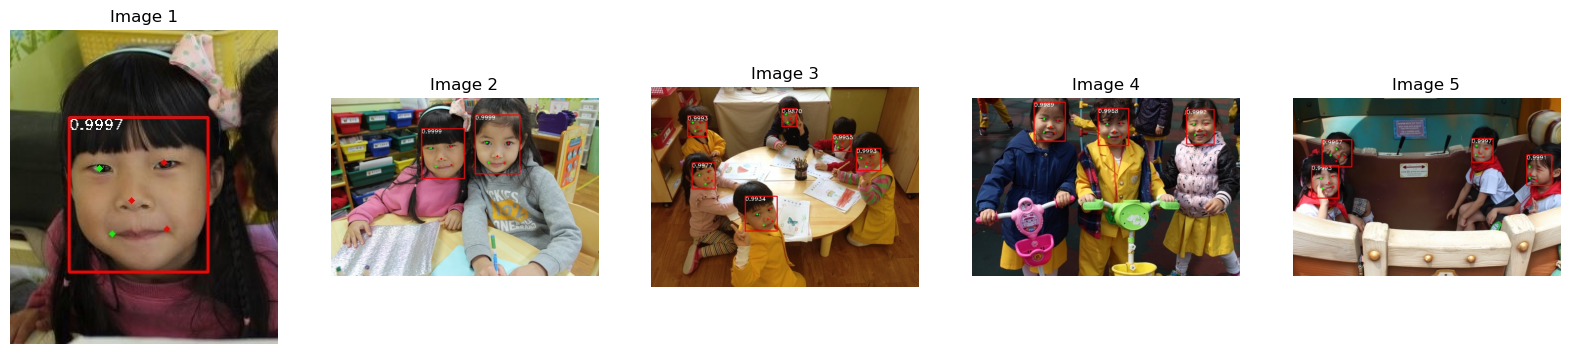

In [12]:
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(20, 5))

for i, image_file in enumerate(output_files[:num_images_to_plot]):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')

plt.show()